In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import sys
sys.path.insert(0,'../code/functions/')
sys.path.insert(0,'../code/tests/')
from precisionRecall import generateTestVolume, applyGradient, precision_recall_f1
import connectLib as cLib
import plosLib as pLib
import mouseVis as mv 
import tiffIO as tIO
import cv2
from random import randrange as rand
import scipy.ndimage as ndimage
import plotly
plotly.offline.init_notebook_mode()
from IPython.display import IFrame
from connectLib import clusterThresh

# Pseudocode & Motivation
The motivation for this algorithm is to mitigate the current por performance on volumes that have areas of very dense, high intensity voxels. The current adaptive threshold metric will perform poorly in these areas since there is not enough variance within a neighborhood to determine what should be considered "foreground" and what should not be.

The following algorithm attempts to mitigate this by expanding the neighborhood around a target until there is enough varience for the neighborhood itself to be taken in context with the rest of the image.

In [2]:
IFrame("expanding_adaptive.pdf", width=600, height=600)

# Algorithm Code

In [3]:
def binaryThreshold(img, percentile=90):
    img = (img/256).astype('uint8')
    threshImg = np.zeros_like(img)
    percentile = np.percentile(img, percentile)
    for i in range(len(img)):
        threshImg[i] = cv2.threshold(img[i], percentile, 255, cv2.THRESH_TOZERO)[1]
    return threshImg

def expandingAdaptive(inImg, sx, sy, p, minStd):
    
    max = np.max(inImg)
    outImg = np.zeros_like(inImg)
    shape = outImg.shape
    sz = shape[0]
    subzLen = shape[0]/sz
    subYLen = shape[1]/sy
    subxLen = shape[2]/sx
    
    for zInc in range(1, sz + 1):
        for yInc in range(1, sy + 1):
            for xInc in range(1, sx + 1):
                
                sub = inImg[(zInc-1)*subzLen: zInc*subzLen, (yInc-1)*subYLen: yInc*subYLen, (xInc-1)*subxLen: xInc*subxLen]
                target = sub
                xlGrowth = 0
                xrGrowth = 0
                ylGrowth = 0
                yrGrowth = 0
                
                while(np.std(sub)<minStd):
                    
                    if (yInc-1)*(subyLen+ylGrowth+1) >= 0:
                        ylGrowth+=1
                    if yInc*(subyLen+yrGrowth+1) <outImg.shape[1]:
                        yrGrwoth+=1
                        
                    if (xInc-1)*(subxLen+xlGrowth+1) >= 0:
                        xlGrowth+=1
                    if xInc*(subxLen+xrGrowth+1) <outImg.shape[2]:
                        xrGrwoth+=1
                    
                    sub = inImg[(zInc-1)*subzLen: zInc*subzLen,
                                (yInc-1)*(subYLen+ylGrowth): yInc*(subYLen+yrGrowth),
                                (xInc-1)*(subxLen+xlGrowth): xInc*(subxLen+xrGrowth)]

                
                subThresh = binaryThreshold(sub, p)[:,ylGrowth:-yrGrowth, xlGrowth:-xrGrowth]
                
                outImg[(zInc-1)*subzLen: zInc*subzLen,
                       (yInc-1)*subYLen: yInc*subYLen,
                       (xInc-1)*subxLen: xInc*subxLen] = subThresh
    return outImg

# Current Algorithm
Below is the current adaptive threshold algorithm. It will be used for comparison purposes with the expanding version

In [4]:
def adaptiveThreshold(inImg, sx, sy, p):
    myMax = np.max(inImg)
    outImg = np.zeros_like(inImg)
    shape = outImg.shape
    sz = shape[0]
    subzLen = shape[0]/sz
    subYLen = shape[1]/sy
    subxLen = shape[2]/sx
    for zInc in range(1, sz + 1):
        for yInc in range(1, sy + 1):
            for xInc in range(1, sx + 1):
                sub = inImg[(zInc-1)*subzLen: zInc*subzLen, (yInc-1)*subYLen: yInc*subYLen, (xInc-1)*subxLen: xInc*subxLen]
                subThresh = binaryThreshold(sub, p)
                outImg[(zInc-1)*subzLen: zInc*subzLen, (yInc-1)*subYLen: yInc*subYLen, (xInc-1)*subxLen: xInc*subxLen] = subThresh
    return outImg

In [5]:
def adaptiveThresholdSTDEV(inImg, sx, sy, p):
    myMax = np.max(inImg)
    outImg = np.zeros_like(inImg)
    shape = outImg.shape
    sz = shape[0]
    subzLen = shape[0]/sz
    subYLen = shape[1]/sy
    subxLen = shape[2]/sx
    stdDevList = []
    for zInc in range(1, sz + 1):
        for yInc in range(1, sy + 1):
            for xInc in range(1, sx + 1):
                sub = inImg[(zInc-1)*subzLen: zInc*subzLen, (yInc-1)*subYLen: yInc*subYLen, (xInc-1)*subxLen: xInc*subxLen]
                stdDevList.append(np.std(sub))
                subThresh = binaryThreshold(sub, p)
                outImg[(zInc-1)*subzLen: zInc*subzLen, (yInc-1)*subYLen: yInc*subYLen, (xInc-1)*subxLen: xInc*subxLen] = subThresh
    return stdDevList

# Simulation Data

In [6]:
sparseLabels, sparseVolume = generateTestVolume(1500)

In [7]:
sparseGradVolume = applyGradient(sparseVolume, 0, 0)

In [8]:
denseLabels, denseVolume = generateTestVolume(15000)

In [9]:
denseGradVolume = applyGradient(denseVolume, 0, 0)

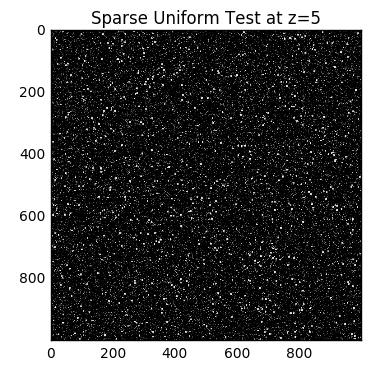

In [10]:
fig = plt.figure()
plt.imshow(sparseVolume[5], cmap='gray')
plt.title("Sparse Uniform Test at z=5")
plt.show()

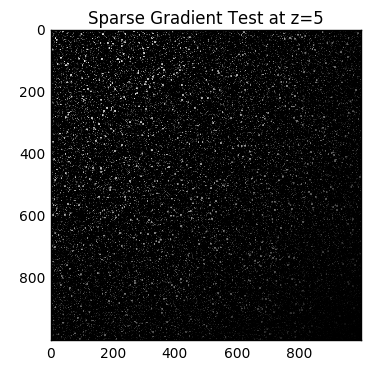

In [11]:
fig = plt.figure()
plt.imshow(sparseGradVolume[5], cmap='gray')
plt.title("Sparse Gradient Test at z=5")
plt.show()

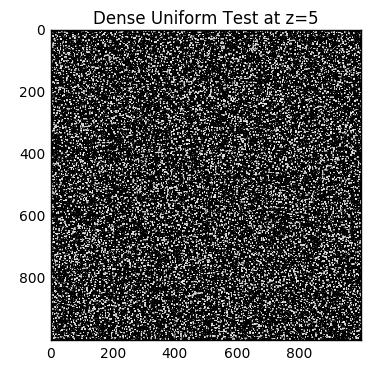

In [12]:
fig = plt.figure()
plt.imshow(denseVolume[5], cmap='gray')
plt.title("Dense Uniform Test at z=5")
plt.show()

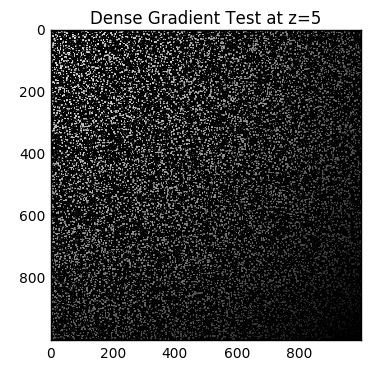

In [13]:
fig = plt.figure()
plt.imshow(denseGradVolume[5], cmap='gray')
plt.title("Dense Gradient Test at z=5")
plt.show()

In [14]:
adaptiveSparseUniform = adaptiveThreshold(sparseVolume, 64, 64, 90)
adaptiveSparseGradient = adaptiveThreshold(sparseGradVolume, 64, 64, 90)
adaptiveDenseUniform = adaptiveThreshold(denseVolume, 64, 64, 90)
adaptiveDenseGradient = adaptiveThreshold(denseGradVolume, 64, 64, 90)

In [15]:
aSU_STDEV = adaptiveThresholdSTDEV(sparseVolume, 64, 64, 90)

In [16]:
aDU_STDEV = adaptiveThresholdSTDEV(denseVolume, 64, 64, 90)

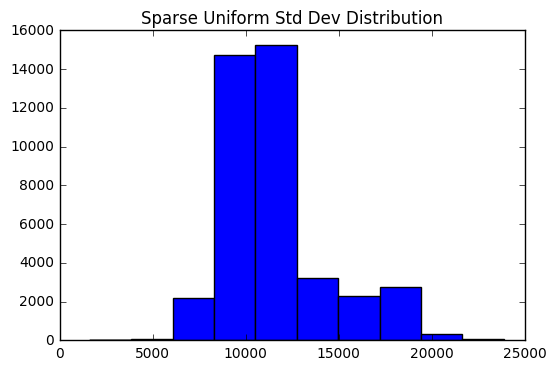

In [17]:
plt.figure()
plt.hist(aSU_STDEV)
plt.title("Sparse Uniform Std Dev Distribution")
plt.show()

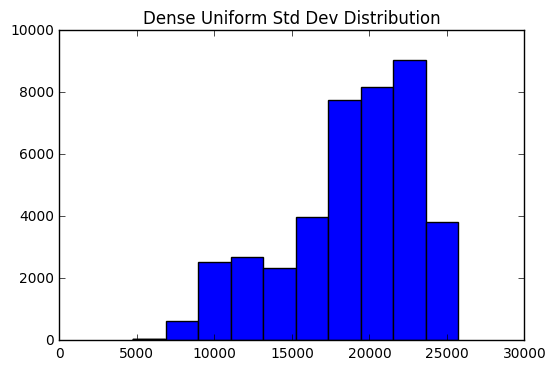

In [18]:
plt.figure()
plt.hist(aDU_STDEV)
plt.title("Dense Uniform Std Dev Distribution")
plt.show()

# This is unexpected
Our main hypothesis for believing that the adaptive threshold was not working was that the variance in each of the neighborhoods was too small in the more uniform dense sims. This, as can be seen from the above histograms, is not the case. The motivation behind the expanding neighborhood, then, is somewhat ill founded.

However, it is still interesting that both distributions are slightly bimodal, with the principle mode at the approximate position of the non-principal node of the other.

# New Goal - Diagnose what is actually happening
Before I can fix the issue with the dense simulations, I need to figure out the root cause of why the neighborhood threshold is actuall failing there.

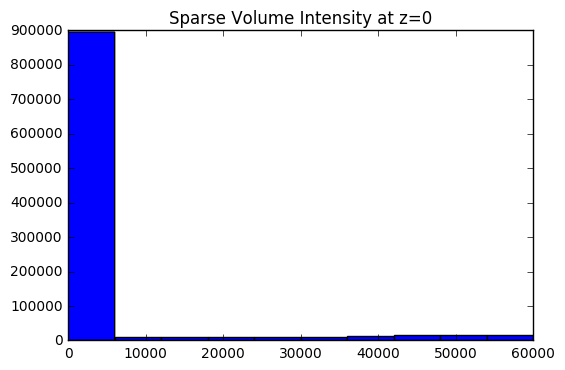

In [19]:
plt.figure()
plt.hist(sparseVolume[0].flatten())
plt.title("Sparse Volume Intensity at z=0")
plt.show()

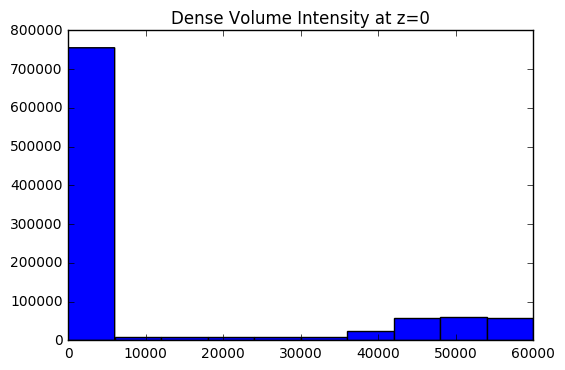

In [20]:
plt.figure()
plt.hist(denseVolume[0].flatten())
plt.title("Dense Volume Intensity at z=0")
plt.show()

I decided a good next step would be to peek at the disperity in our predictions and the data to find where the drop in f1 was coming from. The following code displays red for a false positive, blue for a false negative, and green for true positive. 

In [21]:
def toDiff(imgA, imgB):
    ret = np.empty((imgA.shape[0], imgA.shape[1], 3), dtype=np.uint8)
    for y in range(imgA.shape[0]):
        for x in range(imgA.shape[1]):
            
            if imgA[y][x] and not imgB[y][x]:
                ret[y][x][0] = 255
                ret[y][x][1] = 0
                ret[y][x][2] = 0
            elif not imgA[y][x] and imgB[y][x]:
                ret[y][x][0] = 0
                ret[y][x][1] = 0
                ret[y][x][2] = 255
            elif imgA[y][x] and imgB[y][x]:
                ret[y][x][0] = 0
                ret[y][x][1] = 255
                ret[y][x][2] = 0
            else:
                ret[y][x][0] = 255
                ret[y][x][1] = 255
                ret[y][x][2] = 255
            
    return ret

def visDiff(sliceA, sliceB):
    disp = toDiff(sliceA, sliceB)
    return disp

def visVolDiff(volumeA, volumeB):
    for i in range(volumeA.shape[0]):
        plt.figure()
        plt.title('Disperity at z=' + str(i))
        plt.imshow(visDiff(volumeA[i], volumeB[i]))
        plt.show()


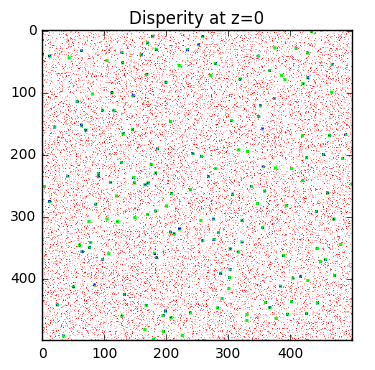

In [22]:
visVolDiff(adaptiveSparseUniform[:1, :500, :500], sparseLabels[:1, :500, :500])

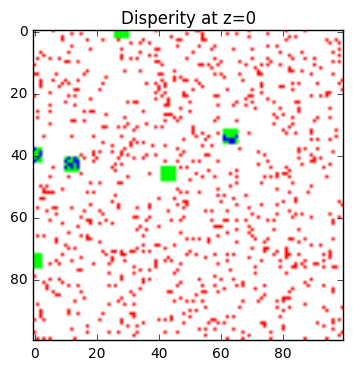

In [23]:
visVolDiff(adaptiveSparseUniform[:1, :100, :100], sparseLabels[:1, :100, :100])

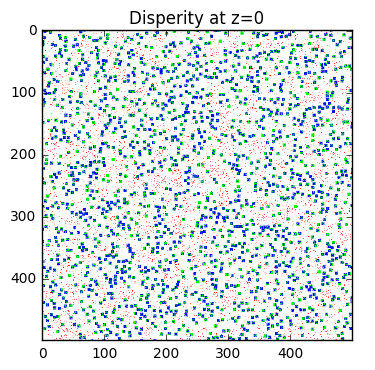

In [24]:
visVolDiff(adaptiveDenseUniform[:1, :500, :500], denseLabels[:1, :500, :500])

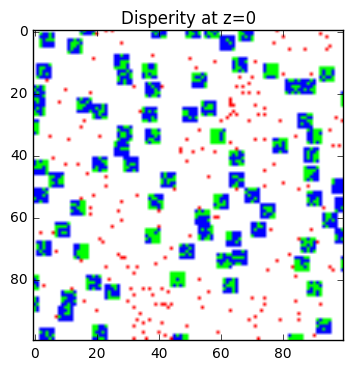

In [25]:
visVolDiff(adaptiveDenseUniform[:1, :100, :100], denseLabels[:1, :100, :100])

# Metric Definition
The older precision recall code takes quite a long time to run as it is performing a n^2 operation (matching predicted clusters to all label clusters). This is inappropriate for this scenario as clustering adds another level of potential error to the situation. Thus, I define a "fast prm" below that is optimized to run in this scenario, quickly

In [26]:
def fast_prf(labels, predictions):
    false_positive = np.logical_and((predictions > 0), (labels == 0))
    true_positive = np.logical_and((predictions >0), (labels != 0))
    
    fpc = np.count_nonzero(false_positive)
    tpc = np.count_nonzero(true_positive)
    
    precision = tpc/float(fpc+tpc)
    
    false_negatives = np.count_nonzero(np.logical_and((predictions == 0),(labels !=0)))
    relevant_items = np.count_nonzero(labels != 0)
    
    recall = (relevant_items - false_negatives)/float(relevant_items)
    
    f1 = (2*precision*recall)/(precision+recall)
    
    return precision, recall, f1

# Scoring
The cells below show our "raw" precision recall scores for the algorithm

In [27]:
precision, recall, f1 = fast_prf(sparseLabels, adaptiveSparseUniform)
print precision
print recall
print f1

0.134037339999
0.719633661229
0.225983503214


In [28]:
precision, recall, f1 = fast_prf(denseLabels, adaptiveDenseUniform)
print precision
print recall
print f1

0.724147401903
0.418066327602
0.53009631584


This is not super, as it does not match what Will reported earlier, HOWEVER, I have a hunch that performance will skyrocket after one minor adjustment. 

Our clustering code rids all clusters that only have a single member, and, visually, this seems to be the case for a large number of our predictions. Additionally, most clusters have a group of relatively dense true positives on them.

Because of these relationships, I think that a knn filter will get rid of most of the false positives and increase the number of true positives

In [72]:
def knn_filter(volume, n):
    #neighborList = []
    outVolume = np.zeros_like(volume)
    #for all voxels in volume
    for z in range(volume.shape[0]):
        for y in range(volume.shape[1]):
            for x in range(volume.shape[2]):
                #get all valid neighbors
                neighbors = []
                for a in (-1, 1):
                    try:
                        neighbors.append(volume[z][y+a][x])
                        neighbors.append(volume[z][y][x+a])

                    #just keep going and append nothing if on edge
                    except IndexError:
                        continue
                
                #if at least half of your neighbors are true, be true
                #neighborList.append(np.count_nonzero(neighbors))
                if np.count_nonzero(neighbors) >= n:
                    outVolume[z][y][x] = 1
                else:
                    outVolume[z][y][x] = 0
                    
    return outVolume

In [73]:
knn_adaptiveSparseUniform_1 = knn_filter((adaptiveSparseUniform != 0), 1)
knn_adaptiveSparseUniform_2 = knn_filter((adaptiveSparseUniform != 0), 2)
knn_adaptiveSparseUniform_3 = knn_filter((adaptiveSparseUniform != 0), 3)

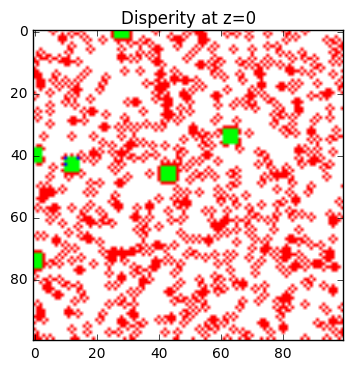

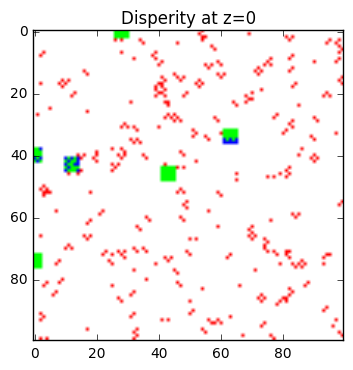

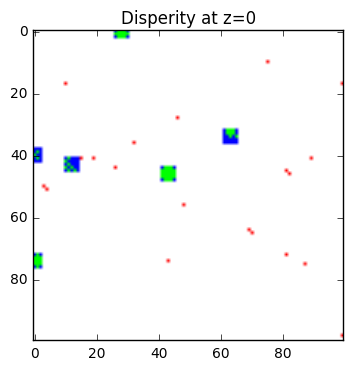

In [74]:
visVolDiff(knn_adaptiveSparseUniform_1[:1, :100, :100], sparseLabels[:1, :100, :100])
visVolDiff(knn_adaptiveSparseUniform_2[:1, :100, :100], sparseLabels[:1, :100, :100])
visVolDiff(knn_adaptiveSparseUniform_3[:1, :100, :100], sparseLabels[:1, :100, :100])

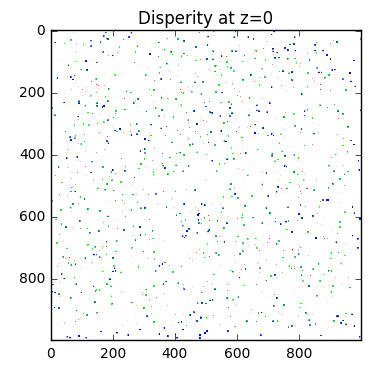

In [76]:
visVolDiff(knn_adaptiveSparseUniform_3[:1], sparseLabels[:1])

In [81]:
precision, recall, f1 = fast_prf(sparseLabels, knn_adaptiveSparseUniform_1)
print precision
print recall
print f1

0.0509681700014
0.902975731598
0.0964899938414


In [82]:
precision, recall, f1 = fast_prf(sparseLabels, knn_adaptiveSparseUniform_2)
print precision
print recall
print f1

0.262285384564
0.779345647414
0.392482494406


In [75]:
precision, recall, f1 = fast_prf(sparseLabels, knn_adaptiveSparseUniform_3)
print precision
print recall
print f1

0.790034810723
0.491288661383
0.605834752981


In [78]:
knn_adaptiveDenseUniform_1 = knn_filter((adaptiveDenseUniform != 0), 1)
knn_adaptiveDenseUniform_2 = knn_filter((adaptiveDenseUniform != 0), 2)
knn_adaptiveDenseUniform_3 = knn_filter((adaptiveDenseUniform != 0), 3)

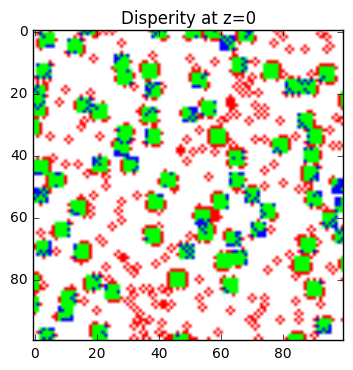

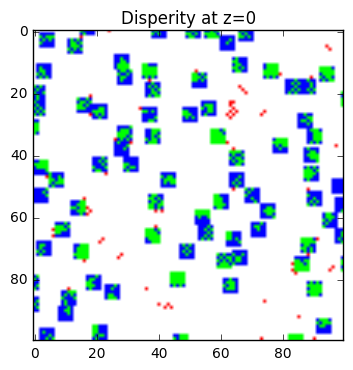

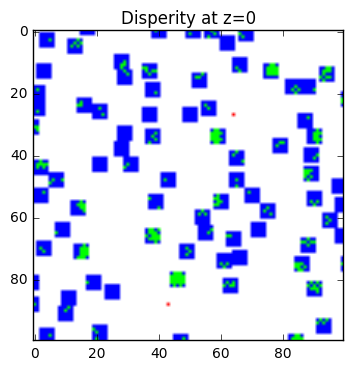

In [80]:
visVolDiff(knn_adaptiveDenseUniform_1[:1, :100, :100], denseLabels[:1, :100, :100])
visVolDiff(knn_adaptiveDenseUniform_2[:1, :100, :100], denseLabels[:1, :100, :100])
visVolDiff(knn_adaptiveDenseUniform_3[:1, :100, :100], denseLabels[:1, :100, :100])

In [83]:
precision, recall, f1 = fast_prf(denseLabels, knn_adaptiveDenseUniform_1)
print precision
print recall
print f1

0.460114885115
0.750514707956
0.570484961882


In [86]:
precision, recall, f1 = fast_prf(denseLabels, knn_adaptiveDenseUniform_2)
print precision
print recall
print f1

0.863495952007
0.423269500146
0.568077887656


In [87]:
precision, recall, f1 = fast_prf(denseLabels, knn_adaptiveDenseUniform_3)
print precision
print recall
print f1

0.982354248875
0.155090516525
0.267887870257


In [90]:
pMat = []
rMat = []
fMat = []

for n in [1, 2, 3, 4]:
    pa, ra, f1a = fast_prf(sparseLabels, knn_filter((adaptiveSparseUniform != 0), n))
    pb, rb, f1b = fast_prf(sparseLabels, knn_filter((adaptiveSparseGradient != 0), n))
    pc, rc, f1c = fast_prf(denseLabels, knn_filter((adaptiveDenseUniform != 0), n))
    pd, rd, f1d = fast_prf(denseLabels, knn_filter((adaptiveDenseGradient != 0), n))
    pMat.append([pa, pb, pc, pd])
    rMat.append([ra, rb, rc, rd])
    fMat.append([f1a, f1b, f1c, f1d])

In [97]:
pa, ra, f1a = fast_prf(sparseLabels,adaptiveSparseUniform)
pb, rb, f1b = fast_prf(sparseLabels,adaptiveSparseGradient)
pc, rc, f1c = fast_prf(denseLabels, adaptiveDenseUniform)
pd, rd, f1d = fast_prf(denseLabels, adaptiveDenseGradient)
pMat.append([pa, pb, pc, pd])
rMat.append([ra, rb, rc, rd])
fMat.append([f1a, f1b, f1c, f1d])

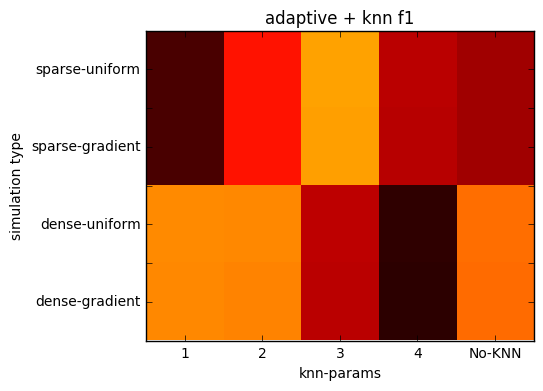

In [101]:
plt.figure()
fig, ax = plt.subplots()
plt.imshow(np.transpose(fMat), interpolation='nearest', cmap='hot', vmin=0, vmax=1)
plt.title('adaptive + knn f1')
ax.set_xlabel('knn-params')
ax.set_ylabel('simulation type')
ax.set_xticklabels(['', '1', '2', '3', '4', 'No-KNN'])
ax.set_yticklabels(['', 'sparse-uniform', '', 'sparse-gradient', '', 'dense-uniform', '', 'dense-gradient'])
plt.show()

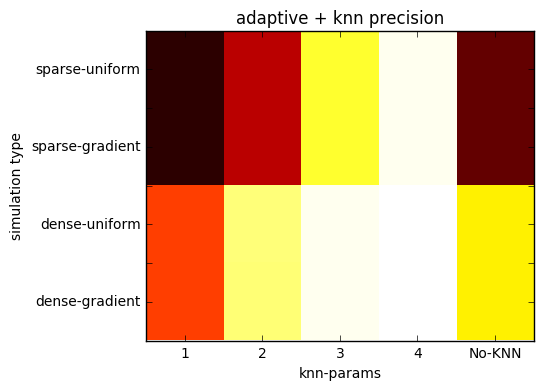

In [102]:
plt.figure()
fig, ax = plt.subplots()
plt.imshow(np.transpose(pMat), interpolation='nearest', cmap='hot', vmin=0, vmax=1)
plt.title('adaptive + knn precision')
ax.set_xlabel('knn-params')
ax.set_ylabel('simulation type')
ax.set_xticklabels(['', '1', '2', '3', '4', 'No-KNN'])
ax.set_yticklabels(['', 'sparse-uniform', '', 'sparse-gradient', '', 'dense-uniform', '', 'dense-gradient'])
plt.show()

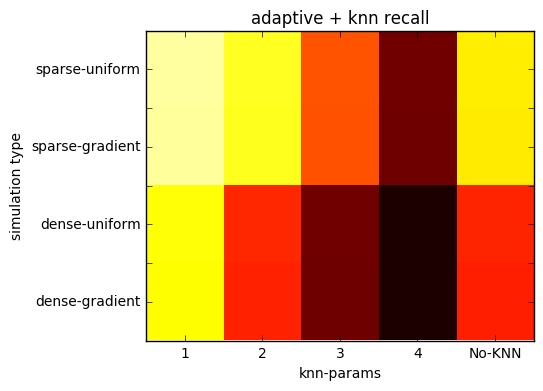

In [103]:
plt.figure()
fig, ax = plt.subplots()
plt.imshow(np.transpose(rMat), interpolation='nearest', cmap='hot', vmin=0, vmax=1)
plt.title('adaptive + knn recall')
ax.set_xlabel('knn-params')
ax.set_ylabel('simulation type')
ax.set_xticklabels(['', '1', '2', '3', '4', 'No-KNN'])
ax.set_yticklabels(['', 'sparse-uniform', '', 'sparse-gradient', '', 'dense-uniform', '', 'dense-gradient'])
plt.show()